# HW 2: Ensemble Learning
## Random forests

We'll first setup the environment

In [13]:
# For the matrix math
import numpy as np
# For data manipulation
import pandas as pd
# For rendering the plots
import matplotlib.pyplot as plt
import pylab as pl
# For shuffling, folding and splitting the train and test data
from sklearn import cross_validation
from sklearn import preprocessing
# For calculating performance metrics
from sklearn.metrics import confusion_matrix, accuracy_score, zero_one_loss
# For classifying verification metrics
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format='svg'
%matplotlib inline

Then load in the data

In [3]:
spam_DF = pd.read_csv('data/spambase.data',header=None)
# spam_DF
# spam_DF.describe()

In [4]:
alcohol_DF = pd.read_csv('data/alcoholism.csv', delim_whitespace=True)
# alcohol_DF
# alcohol_DF.describe()

In [5]:
musicgenre_DF = pd.read_csv('data/genre_classification.txt', delim_whitespace=True)
# musicgenre_DF
# musicgenre_DF.describe()

In [25]:
wine_DF = pd.read_csv('data/wine.data')
# wine_DF
# wine_DF.describe()
# wine_DF.tail()

In [26]:
spam_X = np.matrix(spam_DF[range(0,57)])
spam_y = np.array(spam_DF[57])
spam = {'Lable': 'Spam', 'X': spam_X, 'y': spam_y}

alcohol_X = np.matrix(alcohol_DF[['f1','f2','f3','f4','f5','f6']])
alcohol_y = np.array(alcohol_DF['c'])
alcohol = {'Lable': 'Alcoholism', 'X': alcohol_X, 'y': alcohol_y}

musicgenre_X = np.matrix(musicgenre_DF[['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10']])
musicgenre_y = np.array(musicgenre_DF['c'])
musicgenre = {'Lable': 'Music Genre', 'X': musicgenre_X, 'y': musicgenre_y}

wine_X = np.matrix(wine_DF[['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13']])
wine_y = np.array(wine_DF['c'])
wine = {'Lable': 'Alcoholism', 'X': wine_X, 'y': wine_y}

dataSets = [spam, alcohol, musicgenre, wine]

Then make some nice plotting error functions to generate all the tests needed for rendering figures.

In [7]:
def plot_error(clf, X_TD, X_TtD, y_TD, y_TtD, n_estimators, oob_step=25):
    # Make a dict for containing the data
    data = {}
    
    # Get the Test Error
    # Init the n_estimators to original value
    clf.set_params(n_estimators=n_estimators)
    # Make a container for the error
    rfc_err = np.zeros((n_estimators,))
    # Fit our classifier
    clf = clf.fit(X_TD, y_TD)
    # For each number of n_estimators used
    for i in np.arange(n_estimators):
        # Init the current n_estimators value
        clf.set_params(n_estimators=i+1)
        # Get the predictions
        y_pred = clf.predict(X_TtD)
        # Now lets get the error
        rfc_err[i] = zero_one_loss(y_TtD, y_pred)
    data['RFC Test Error'] = {'x': np.arange(n_estimators) + 1, 'y': rfc_err}
    
    # Get the Train Error
    # Init the n_estimators to original value
    clf.set_params(n_estimators=n_estimators)
    # Make a container for the error
    rfc_err_train = np.zeros((n_estimators,))
    # Fit our classifier
    clf = clf.fit(X_TD, y_TD)
    # For each number of n_estimators used
    for i in np.arange(n_estimators):
        # Init the current n_estimators value
        clf.set_params(n_estimators=i+1)
        # Get the predictions
        y_pred = clf.predict(X_TD)
        # Now lets get the error
        rfc_err_train[i] = zero_one_loss(y_TD, y_pred)
    data['RFC Train Error'] = {'x': np.arange(n_estimators) + 1, 'y': rfc_err_train}
    
    
    # Get the CV Train Error
    n_folds=4
    # Init the n_estimators to original value
    clf.set_params(n_estimators=n_estimators)
    # Make a container for the error
    rfc_err_train_cv = np.zeros((n_estimators,n_folds))
    kf = cross_validation.KFold(X_TD.shape[0],n_folds=n_folds)
    # For each number of n_estimators used
    for nf, [train_index, test_index] in enumerate(kf):
        X_train, X_test = X_TD[train_index], X_TD[test_index]
        y_train, y_test = y_TD[train_index], y_TD[test_index]
        # Init the n_estimators to original value
        clf.set_params(n_estimators=n_estimators)
        # Fit our CV classifier
        clf = clf.fit(X_train,y_train)
        for i in np.arange(n_estimators):
            # Init the current n_estimators value
            clf.set_params(n_estimators=i+1)
            # Get the predictions
            y_pred = clf.predict(X_test)
            # Now lets get the error
            rfc_err_train_cv[i,nf] = zero_one_loss(y_test, y_pred)
    # Take the mean over all folds for each point
    data['RFC Train Error CV'] = {'x': np.arange(n_estimators) + 1, 'y': rfc_err_train_cv.mean(1)}
    
    # Get the Out-Of-Bag Error
    n_estimats = np.arange(0,n_estimators+1,oob_step)
    # Init the n_estimators to original value
    clf.set_params(n_estimators=n_estimators, oob_score=True)
    # Make a container for the error
    rfc_err_ooc = np.zeros((n_estimats.size,)) 
    for i,j in enumerate(n_estimats):
        # Lets print our progress
        print 'OOB irt: ', i
        # Init the current n_estimators value
        clf.set_params(n_estimators=j+1)
        # Re fit with new n_estimators
        clf = clf.fit(X_TD, y_TD)
        # Now lets get the error
        rfc_err_ooc[i] = 1.0 - clf.oob_score_
    data['RFC OOB Error'] = {'x': n_estimats + 1, 'y': rfc_err_ooc}
    
    return data
    
def plot_fig(data, x_bound, y_bound):
    
    fig = plt.figure(figsize=[8,4])
    ax = fig.add_subplot(111)
    
    for lable, error in data.items():
        ax.plot(error['x'], error['y'],
            label=lable)
    
    ax.set_ylim(y_bound)
    ax.set_xlim(x_bound)
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('error rate')
        
    handles, labels = ax.get_legend_handles_labels()
        
    # or sort them by labels
    import operator
    hl = sorted(zip(handles, labels),
                key=operator.itemgetter(1))
    handles2, labels2 = zip(*hl)
    
    ax.legend(handles2, labels2)
    
    leg = ax.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    ax.grid()
    
    return fig

Here we'll be use some primitive baseclasses and some coding guidelines from scikit to make our classifier.

In [8]:
from __future__ import division
import numbers
import itertools
from abc import ABCMeta, abstractmethod
from sklearn.base import ClassifierMixin, BaseEstimator
# Six provides simple utilities for wrapping over differences between Python 2 and Python 3
from sklearn.externals import six
from sklearn.externals.six.moves import xrange
from sklearn.feature_selection.from_model import _LearntSelectorMixin
from sklearn.tree._tree import DTYPE, DOUBLE
from sklearn.utils import array2d, check_random_state, check_arrays, safe_asarray, column_or_1d
from sklearn.utils.fixes import bincount, unique
from sklearn.tree._tree import Tree, Entropy, BestSplitter
from sklearn.ensemble.base import BaseEnsemble

In [9]:
class myDecisionTreeClassifier(six.with_metaclass(ABCMeta, BaseEstimator, _LearntSelectorMixin, ClassifierMixin)):
    
    def __init__(self,
                 # Max depth for Decision Tree
                 max_depth=None,
                 # Min number of samples per split
                 min_samples_split=2,
                 # Min samples per leaf node
                 min_samples_leaf=1,
                 # Max number of features to consider when looking for the best split
                 max_features=None,
                 # Init the random state of the tree
                 random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        # We'll waint until we fit to inti these:
        # Learning criterion for training tree
        self.criterion = None
        # Split method
        self.splitter = None
        # Number of features
        self.n_features_ = None
        # Number of outputs
        self.n_outputs_ = None
        # Labels of classes
        self.classes_ = None
        # Number of classes
        self.n_classes_ = None
        # Tree dataframe
        self.tree_ = None
        
    def fit(self, X, y, check_input=True, sample_weight=None):
        # Poll the randome state from the tree
        random_state = check_random_state(self.random_state)
        # If the data hasn't yet been formated
        if check_input:
            # Then convert the X data
            X, = check_arrays(X, dtype=DTYPE, sparse_format="dense", check_ccontiguous=True)
        # Get the dimentions of X
        n_samples, self.n_features_ = X.shape
        # Make sure that y is a 1d and not a id.T
        y = np.atleast_1d(y)
        # If our output is 1d
        if y.ndim == 1:
            # Reshape y to preserve the data contiguity
            y = np.reshape(y, (-1, 1))
        # Get the number of outputs
        self.n_outputs_ = y.shape[1]
        y = np.copy(y)
        # Make a container for all unique classes
        self.classes_ = []
        # Make a container for number of instances of each unique classe
        self.n_classes_ = []
        # For each output of y
        for k in xrange(self.n_outputs_):
            # Get the unique classe lables and an array of indexs pointing to the lable
            classes_k, y[:, k] = unique(y[:, k], return_inverse=True)
            # Store the unique classe lables
            self.classes_.append(classes_k)
            # And store the unique classe lables' length
            self.n_classes_.append(classes_k.shape[0])
        # Lets make this numpy array type ints for speed
        self.n_classes_ = np.array(self.n_classes_, dtype=np.intp)
        if getattr(y, "dtype", None) != DOUBLE or not y.flags.contiguous:
            y = np.ascontiguousarray(y, dtype=DOUBLE)
        # Check parameters
        # If no maxdepth was given
        max_depth = (2 ** 31) - 1 if self.max_depth is None else self.max_depth
        # If defult was given 
        if isinstance(self.max_features, six.string_types):
            # then set it to the sqrt of number of features 
            max_features = max(1, int(np.sqrt(self.n_features_)))
        # If None was given 
        elif self.max_features is None:
            # Just use all of them
            max_features = self.n_features_
        # Otherwise
        else:
            # Use whats given
            max_features = self.max_features
        # We we we're given a sample weight
        if sample_weight is not None:
            # Then  we'll nedd to make sure its double precision
            if (getattr(sample_weight, "dtype", None) != DOUBLE or not sample_weight.flags.contiguous):
                sample_weight = np.ascontiguousarray(sample_weight, dtype=DOUBLE)
        min_samples_split = self.min_samples_split
        criterion = self.criterion
        # If we have not yet inti our tree criterion
        if criterion is None:
            # Lets inti our entropy criterion
            criterion = Entropy(self.n_outputs_, self.n_classes_)
        splitter = self.splitter
        # If we have not yet inti our tree splitter
        if splitter is None:
            # Lets inti our best binary splitter
            splitter = BestSplitter(criterion, max_features, self.min_samples_leaf, random_state)
        # We'll save these so we don't have to init them agian a second time for retraining
        self.criterion_ = criterion
        self.splitter_ = splitter
        # Now lets init
        self.tree_ = Tree(self.n_features_, self.n_classes_, self.n_outputs_, splitter, max_depth, min_samples_split, self.min_samples_leaf, random_state)
        # and fit our tree database
        self.tree_.build(X, y, sample_weight=sample_weight)
        # If we only have one output
        if self.n_outputs_ == 1:
            # Then just save the first class
            self.n_classes_ = self.n_classes_[0]
            self.classes_ = self.classes_[0]
        # Then save our tree
        return self

    def predict(self, X):
        """Predict class for a given X"""
        # Make sure the data is DTYPE for the tree and is 2D
        if getattr(X, "dtype", None) != DTYPE or X.ndim != 2:
            X = array2d(X, dtype=DTYPE)
        # Get the dimentions of X
        n_samples, n_features = X.shape
        # Predict class from tree database
        proba = self.tree_.predict(X)
        # If we only have one output
        if self.n_outputs_ == 1:
            # Then use the index of the max prob to pick the class from classes_
            return self.classes_.take(np.argmax(proba, axis=1), axis=0)
        # If we were trained with multiple outputs
        else:
            # Make a empty 2D array to hold predictions
            predictions = np.zeros((n_samples, self.n_outputs_))
            # For each output
            for k in xrange(self.n_outputs_):
                # Then use the index of the max prob to pick the class from classes_
                predictions[:, k] = self.classes_[k].take(np.argmax(proba[:, k], axis=1), axis=0)
            # Return the results
            return predictions

    def predict_proba(self, X):
        """Predict class probabilities from the given X"""
        # Make sure the data is DTYPE for the tree and is 2D
        if getattr(X, "dtype", None) != DTYPE or X.ndim != 2:
            X = array2d(X, dtype=DTYPE)
        # Get the dimentions of X
        n_samples, n_features = X.shape
        # Predict class from tree database
        proba = self.tree_.predict(X)
        # If we only have one output
        if self.n_outputs_ == 1:
            # Grab the predictions for the avalable classes
            proba = proba[:, :self.n_classes_]
            # Generate a normalizer from all the proba weights
            normalizer = proba.sum(axis=1)[:, np.newaxis]
            # Remap all of the zero normalizer elemnts to one
            # This is so just we can avoid deviding by zero
            normalizer[normalizer == 0.0] = 1.0
            # Now normilize the proba by the total weight sum of each sample
            proba /= normalizer
            # Return the results
            return proba
        # If we were trained with multiple outputs
        else:
            # Make a empty container to hold all proba
            all_proba = []
            # For each output
            for k in xrange(self.n_outputs_):
                # Grab the predictions for the avalable classes
                proba_k = proba[:, k, :self.n_classes_[k]]
                # Generate a normalizer from all the proba weights
                normalizer = proba_k.sum(axis=1)[:, np.newaxis]
                # Remap all of the zero normalizer elemnts to one
                # This is so just we can avoid deviding by zero
                normalizer[normalizer == 0.0] = 1.0
                # Now normilize the proba by the total weight sum of each sample
                proba_k /= normalizer
                # Return the results
                all_proba.append(proba_k)
            # Return the results
            return all_proba

## Random Forests

Now we'll make a Random Forest Classifier using decision trees. We'll also make some functions to grow out forest and predict form out forest.

In [10]:
class myRandomForestClassifier(six.with_metaclass(ABCMeta, BaseEnsemble, _LearntSelectorMixin, ClassifierMixin)):
    """Random Forest Classifier"""
    def __init__(self,
                 # Number of estimators or trees
                 n_estimators=10,
                 # Max depth for Decision Tree
                 max_depth=None,
                 # Min number of samples per split
                 min_samples_split=2,
                 # Min samples per leaf node
                 min_samples_leaf=1,
                 # Number of features to consider when looking for the best split
                 max_features="auto",
                 # Subsample data to train trees
                 bootstrap=True,
                 # Keep the Out-Of-Bag score after fitting
                 oob_score=False,
                 # Init the random state of the forest
                 random_state=None):
        super(myRandomForestClassifier, self).__init__(
            base_estimator=myDecisionTreeClassifier(),
            n_estimators=n_estimators,
            estimator_params=("max_depth", "min_samples_split",
                              "min_samples_leaf", "max_features", "random_state"))
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        
        self.bootstrap = bootstrap
        self.oob_score = oob_score
        self.random_state = random_state

    def fit(self, X, y):
        """Fit a forest of trees from the training set X and y"""
        # Poll the randome state from the forest
        random_state = check_random_state(self.random_state)
        # Reshape y to preserve the data contiguity
        y = np.reshape(y, (-1, 1))
        # Get the dimentions of X
        n_samples, self.n_features_ = X.shape
        # Get the number of outputs for morphing y later
        self.n_outputs_ = y.shape[1]
        # Make a container for all unique classes
        self.classes_ = []
        # Make a container for number of instances of each unique classe
        self.n_classes_ = []
        # For each output of y
        for k in xrange(self.n_outputs_):
            # Get the unique classe lables and an array of indexs pointing to the lable
            classes_k, y[:, k] = unique(y[:, k], return_inverse=True)
            # Store the unique classe lables
            self.classes_.append(classes_k)
            # And store the unique classe lables' length
            self.n_classes_.append(classes_k.shape[0])
        # Check if we need/can do OOB estimation
        if not self.bootstrap and self.oob_score:
            raise ValueError("Can't use OOB estimation " 
                             "if bootstraping is not enabled")
        # Precalculate the random seeds for all trees
        n_trees = self.n_estimators
        seeds = random_state.randint(MAX_INT, size=n_trees)
        # Grow the forest given the
        self.estimators_ = grow_forest(self, X, y, seeds)
        # Check if we need/can do OOB estimation
        if self.oob_score:
            # If so, then do it
            self.get_oob_score(X, y)
        # Decapsulate attributes if only have one output to consider
        if hasattr(self, "classes_") and self.n_outputs_ == 1:
            self.n_classes_ = self.n_classes_[0]
            self.classes_ = self.classes_[0]
        return self

    def predict(self, X):
        """Predict class for X using the forest"""
        # Get the number of samples in X
        n_samples = len(X)
        # Get the probability of each class for all samples
        proba =  predict_forest(self, X)
        # In the specal case of being trained with ouly one output
        if self.n_outputs_ == 1:
            # Then use the index of the max prob to pick the class from classes_
            return self.classes_.take(np.argmax(proba, axis=1), axis=0)
        # If we were trained with multiple outputs
        else:
            # Make a empty 2D array to hold predictions
            predictions = np.zeros((n_samples, self.n_outputs_))
            # For each output
            for k in xrange(self.n_outputs_):
                # Then use the index of the max prob to pick the class from classes_
                predictions[:, k] = self.classes_[k].take(np.argmax(proba[k], axis=1), axis=0)
            # Return the results
            return predictions
        
    def get_oob_score(self, X, y):
        """Calculate the Out-Of-Bag Score if bootstraping"""
        # Get a list of the classes
        classes_ = self.classes_
        # Get the count of all the classs
        n_classes_ = self.n_classes_
        # Get the number of outputs
        n_samples = y.shape[0]
        # Init the score to zero
        oob_score = 0.0
        # Make a container for all decision function
        oob_decision_function = []
        # Make a container for all output predictions
        predictions = []
        # For each output
        for k in xrange(self.n_outputs_):
            # Make a container for all predictions
            predictions.append(np.zeros((n_samples, n_classes_[k])))
        # For each tree in the forest
        for estimator in self.estimators_:
            # Make a mask
            mask = np.ones(n_samples, dtype=np.bool)
            # Then mask all of the indices that the tree was trained from
            mask[estimator.indices_] = False
            # Then ask the tree to predict from only the novel points it's never seen
            p_estimator = estimator.predict_proba(X[mask, :])
            # In the specal case of being trained with ouly one output
            if self.n_outputs_ == 1:
                # Then set that as the only p_estimator
                p_estimator = [p_estimator]
            # Then for each output
            for k in xrange(self.n_outputs_):
                # Add the predictions for the current output
                # But only for the predictions of the novel points
                predictions[k][mask, :] += p_estimator[k]
        # For each output
        for k in xrange(self.n_outputs_):
            # Normilize the predictions made for each output
            # by the number of predictions made
            decision = (predictions[k] / predictions[k].sum(axis=1)[:, np.newaxis])
            # Then stor this oob_decision function
            oob_decision_function.append(decision)
            # Use the majoraty vote to pick the predicted class
            y_pred = classes_[k].take(np.argmax(predictions[k], axis=1), axis=0)
            # Get matchs of predictions to real lables
            matches = y[:, k] == y_pred
            # And tack on the mean correct the oob score
            oob_score += np.mean(matches)
        # In the specal case of being trained with ouly one output
        if self.n_outputs_ == 1:
            # Our score is just the first element
            self.oob_decision_function_ = oob_decision_function[0]
        # If we were trained with multiple outputs
        else:
            # Our score are all element in the container
            self.oob_decision_function_ = oob_decision_function
        # Now normilize this score by the number of outputs used to derive it
        self.oob_score_ = oob_score / self.n_outputs_
    
# A constant for random generation
MAX_INT = np.iinfo(np.int32).max

def grow_forest(forest, X, y, seeds):
    """Grow a forest of random trees"""
    # Convert data
    X, = check_arrays(X, dtype=DTYPE, sparse_format="dense")
    # Make a list container for grown trees
    n_trees = forest.n_estimators
    trees = []
    # For each tree in the forest
    for i in range(n_trees):
        # Make a np.random.RandomState instance from the tree's planting seed
        random_state = check_random_state(seeds[i])
        # generate a random seed for a branching seed
        seed = random_state.randint(MAX_INT)
        # Make a decision tree object
        tree = forest._make_estimator(append=False)
        # Init the tree's RandomState instance with generated seed
        # this will randomize what features the tree will use
        tree.set_params(random_state=check_random_state(seed))
        # If we are bootstraping
        if forest.bootstrap:
            # Then get the number of samples
            n_samples = X.shape[0]
            # To generate a uniform sample weight
            curr_sample_weight = np.ones((n_samples,), dtype=np.float64)
            # Then randomly choses n_samples from all samples with replacement 
            indices = random_state.randint(0, n_samples, n_samples)
            # Use this method of bincount to make a randome benning histogram
            # that will sum up to n_samples
            sample_counts = bincount(indices, minlength=n_samples)
            # Apply these randomized counts to the old uniform weights
            curr_sample_weight *= sample_counts
            # Fit the tree using these new sample weights
            tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
            # Then set the indices of the tree only to the samples that had non-zero weights
            tree.indices_ = sample_counts > 0.
        # If we aren't bootstraping
        else:
            # This just fit the data with no random weights
            tree.fit(X, y, check_input=False)
        # Add the grown tree to the container 
        trees.append(tree)
    # return all of the trained trees
    return trees

def predict_forest(forest, X):
    """Compute predictions from the wisdom of the forest"""
    # Get the current number of trees asked to use
    n_trees = forest.n_estimators
    trees = forest.estimators_[0:n_trees]
    # Get the count classes
    n_classes = forest.n_classes_
    # Get the count outputs
    n_outputs = forest.n_outputs_    
    # The number of samples
    n_samples = X.shape[0]
    # In the specal case of being trained with ouly one output
    if n_outputs == 1:
        # Make a container for predicted proba for each class
        proba = np.zeros((n_samples, n_classes))
        # Fore each tree in forest
        for tree in trees:
            # Ask the tree for proba
            proba_tree = tree.predict_proba(X)
            # If the tree has seen the same number of each class
            # as the forest has seen
            if n_classes == tree.n_classes_:
                # Then tack on the predicted proba
                proba += proba_tree
            # If not
            else:
                # Then for each class the tree has
                for j, c in enumerate(tree.classes_):
                    # Then just tack on the predicted proba for that class                  
                    proba[:, c] += proba_tree[:, j]
        # Normilize the proba by the number of trees used
        proba /= n_trees
    # If we were trained with multiple outputs
    else:
        # Make a container for all outputs
        proba = []
        # For each output
        for k in xrange(n_outputs):
            # Make a container for predicted proba for each class
            proba.append(np.zeros((n_samples, n_classes[k])))
        # Fore each tree in forest
        for tree in trees:
            # Ask the tree for proba
            proba_tree = tree.predict_proba(X)
            # For each output
            for k in xrange(n_outputs):
                # If the tree has seen the same number of each class
                # as the forest has seen
                if n_classes[k] == tree.n_classes_[k]:
                    # Then tack on the predicted proba
                    proba[k] += proba_tree[k]
                # If not
                else:
                    # Then for each class the tree has
                    for j, c in enumerate(tree.classes_[k]):
                        # Then just tack on the predicted proba for that class  
                        proba[k][:, c] += proba_tree[k][:, j]   
                # Normilize the proba by the number of trees used
                proba[k] /= n_trees
    # Return the resulting proba
    return proba

For starters, lets take a look at the Spam, Music, and Alcohol datasets. We'll use the same method of splitting the training and testing data into $75\%$ training and $25\%$ test sets. Then We'll train up two different types of forests, one with the trees grown with a limited branching factor of $5$, and the second grow to their full extent. We'll do this $B$ number of estimators, where $B$ will be $500$ trees. For each of the two forest, will plot the training error, test error, and out-of-bag error. In addition we will also show the training CV error with $kf=4$ folds.

### Dataset: Spam

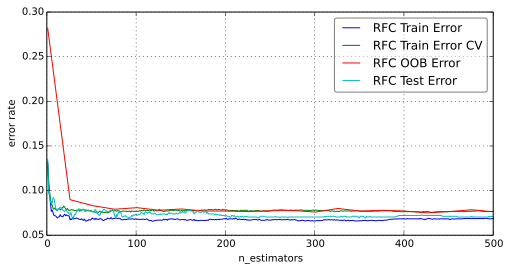

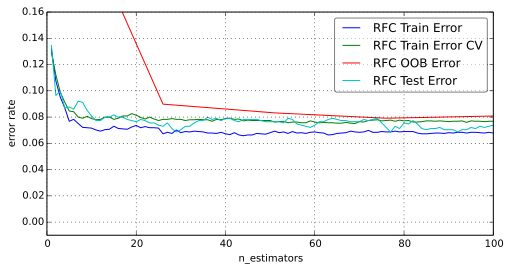

In [14]:
dataSet = spam

X = dataSet['X']
y = dataSet['y']

#Lets split the data making TtD and TD
X_TD, X_TtD, y_TD, y_TtD = cross_validation.train_test_split(X, y, test_size=0.25, random_state=42)


n_estimators = 500
x_bound=[0,100]
y_bound=[-0.01,0.16]

clf = myRandomForestClassifier(n_estimators=n_estimators, max_depth=5)
spam_error_5 = plot_error(clf, X_TD, X_TtD, y_TD, y_TtD, n_estimators)

spam_p1 = plot_fig(spam_error_5, x_bound=[0,n_estimators], y_bound=None)
spam_p2 = plot_fig(spam_error_5, x_bound, y_bound)

spam_p1.show()
spam_p2.show()

Above, we see the errors for an RF with a max depth of $5$. The second figure is a zoomed in section of interest. We can see that the RFC Train Error and the RFC OOB Error serve almost bound the lower and upper limits of performance here. Training Error is obviously the lowest as we are simply asking the forest about the same data used to train it. However, because the trees are limited to a max depth of $5$, a correct majority does not always come to consensus. We'll see how this changes for the second RF type. With OOB Error as the the upper limit here, it's nice to see our Test Error does still better. This could help us to conclude that the given Testing data the forest has never seen before, it can be expected to still out perform a worst case scenario where the forest is evaluated on a tree level, were each is tested only on fewer samples much unlike from it was trained from. As an additional note, Its also cool to see that a CV Training error developed also fits nicely between out OOB and Test Error. This could prove handy if a tighter upper bound of Test Error would like to be estimated if Test Error itself could not be directly calculated.

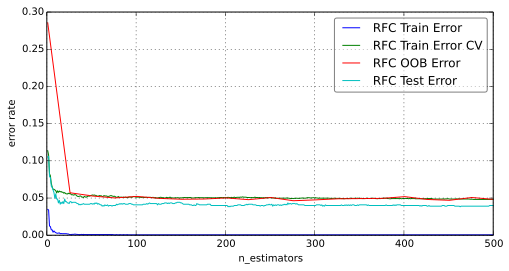

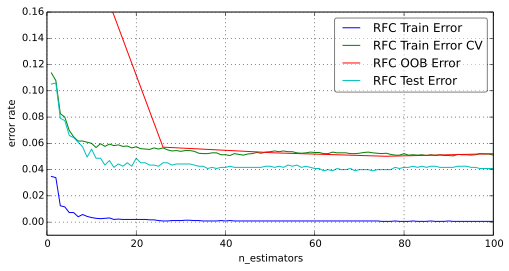

In [16]:
clf = myRandomForestClassifier(n_estimators=n_estimators, max_depth=None)
spam_error_N = plot_error(clf, X_TD, X_TtD, y_TD, y_TtD, n_estimators)

spam_p3 = plot_fig(spam_error_N, x_bound=[0,n_estimators], y_bound=None)
spam_p4 = plot_fig(spam_error_N, x_bound, y_bound)

spam_p3.show()
spam_p4.show()

Above, we see the errors for an RF with a no max depth. The standings of the error is similar, without Train Error lowest the best and OOR Error highest, and our Test Error somewhere in between. However, as alluded to earlier, we see that allowing our decision trees to branch with no limit on depth has allows the Train Error to achieve a $100\%$ accuracy with relatively small number of trees. Thus, when a tree is capable of fully minimizing it's classification error rate, or perhaps entropy, relatively few trees are needed for the forest to recall a correct majority vote. We should notice that the Testing Error also converges to a slightly lower error rate of about $4\%$ vs. the about $7\%$ for max depth of $5$ RF.

### Dataset: Music Genre

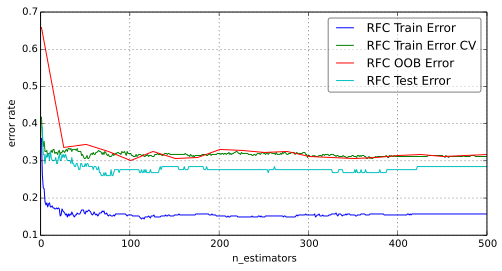

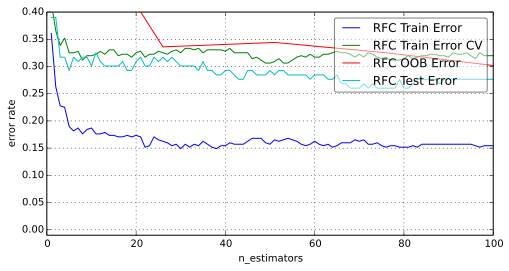

In [18]:
dataSet = musicgenre

X = dataSet['X']
y = dataSet['y']

#Lets split the data making TtD and TD
X_TD, X_TtD, y_TD, y_TtD = cross_validation.train_test_split(X, y, test_size=0.25, random_state=42)


n_estimators = 500
x_bound=[0,100]
y_bound=[-0.01,0.4]

clf = myRandomForestClassifier(n_estimators=n_estimators, max_depth=5)
# musicgenre_error_5 = plot_error(clf, X_TD, X_TtD, y_TD, y_TtD, n_estimators)

musicgenre_p1 = plot_fig(musicgenre_error_5, x_bound=[0,n_estimators], y_bound=None)
musicgenre_p2 = plot_fig(musicgenre_error_5, x_bound, y_bound)

musicgenre_p1.show()
musicgenre_p2.show()

Above, we see the errors for an RF with a max depth of $5$, now for the music genre dataset. We should recall that this dataset has a larger number of classes and fewer percentage of samples per class, thus making the problem a bit more sparse. What's nice to see is that our Test Error converges to under $30\%$ with fewer than about $20$ trees. This is a god deal better that our best $K=23$ with KNN using BIC, having error rate of $41.47\%$ in the last problem set. One thing to note here however is that due to the sparsity, testing out trees on training point never seen proves very challenging for the forest to come to a consensus. So, when experienced trees are left out of the equation, it proves very hard for the forest to come to a correct consensus. Our Train CV Error method still proves valuable here, remaining a solid upper bound estimate of possible Test Error.

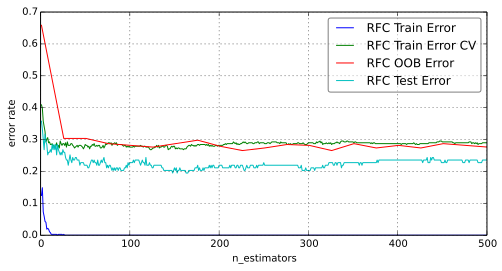

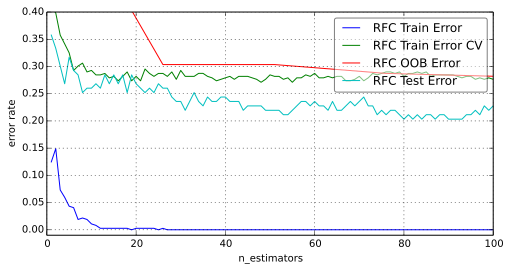

In [20]:
clf = myRandomForestClassifier(n_estimators=n_estimators, max_depth=None)
# musicgenre_error_N= plot_error(clf, X_TD, X_TtD, y_TD, y_TtD, n_estimators)

musicgenre_p3 = plot_fig(musicgenre_error_N, x_bound=[0,n_estimators], y_bound=None)
musicgenre_p4 = plot_fig(musicgenre_error_N, x_bound, y_bound)

musicgenre_p3.show()
musicgenre_p4.show()

Above, we see the errors for an RF with no max depth, now for the music genre dataset. We see the same convergence in Train Error as we saw for the spam dataset, and the same issue that for our OOB Error has with the given sparsity. It seems that even with even no max depth has done little to improve that OOB Error performance. As steadfast as usual, our Train CV Error method still follows closely with our Test Error. Interestingly enough though, Test Error convergence has dropped by about $6\%$, but our CV Error remain more a less no better or worse than before. The one noticeable change in our CV's behavior is perhaps the subtle dip below $30\%$ error around $20$ trees before converging back up to around $33\%$. This could be merely due some random chance of a set of favorable trees chosen during benchmarking. But, seeing as my CV method required retraining during benchmarking, thus 4 times as many trees were involved in converging to that score, there may be a more going on; such as stumbling upon an optimal number of trees for a given number of classes and samples. This is of lesser significance as our primary target is to eventually optimize for Test Error.

### Dataset: Alcoholism

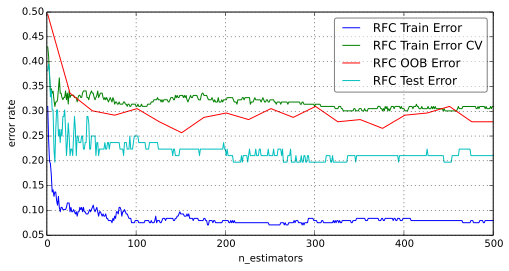

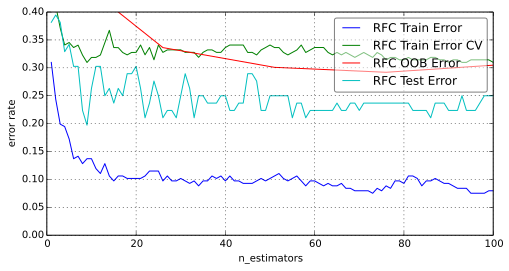

In [23]:
dataSet = alcohol

X = dataSet['X']
y = dataSet['y']

#Lets split the data making TtD and TD
X_TD, X_TtD, y_TD, y_TtD = cross_validation.train_test_split(X, y, test_size=0.25, random_state=42)


n_estimators = 500
x_bound=[0,100]
y_bound=[0.0,0.4]

clf = myRandomForestClassifier(n_estimators=n_estimators, max_depth=5)
# alcohol_error_5 = plot_error(clf, X_TD, X_TtD, y_TD, y_TtD, n_estimators)

alcohol_p1 = plot_fig(alcohol_error_5, x_bound=[0,n_estimators], y_bound=None)
alcohol_p2 = plot_fig(alcohol_error_5, x_bound, y_bound)

alcohol_p1.show()
alcohol_p2.show()

Above, we see the errors for an RF with a max depth of $5$, now for the alcohol dataset. Here we seem to converge to a Test Error of about $20\%$, a bit better that our $36.85\%$ error achieved using our Gaussian Naive Bayes Classifiers as in PS2. This is almost the best we'll see here in PS3, as boosting methods later on will show some improvement over RF. A odd change in ranking is our OOB and CV Errors are now closer together, or have swapped places, with OOB now closer to true Test Error. Just from looking at the alcohol dataset's raw features, one can see how convoluted and difficult the space is to separate. A forest of random decision trees performs as anticipated given the complex structure of the data.

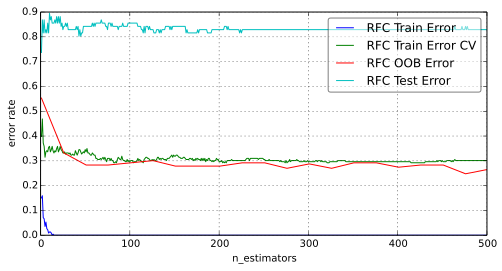

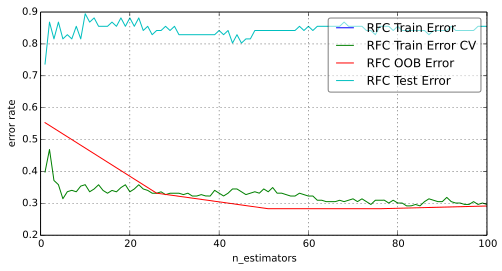

In [24]:
n_estimators = 500
x_bound=[0,100]
y_bound=[0.2,0.9]

clf = myRandomForestClassifier(n_estimators=n_estimators, max_depth=None)
# alcohol_error_N = plot_error(clf, X_TD, X_TtD, y_TD, y_TtD, n_estimators)

alcohol_p3 = plot_fig(alcohol_error_N, x_bound=[0,n_estimators], y_bound=None)
alcohol_p4 = plot_fig(alcohol_error_N, x_bound, y_bound)

alcohol_p3.show()
alcohol_p4.show()

Above, we see the errors for an RF with no max depth, now for the alcohol dataset. Straight away we can quickly see the huge changing in Test Error, now about $83\%$. This suggests that we may be severely overfitting our classifier to the training data, and that by fulling expanding the decision trees to their deepest branches, or when only one class is found in a given leaf node, we lose the generalization necessary to infer about new unseen data. What is also peculiar is that both our CV and OOB Errors fail to reflect this drastic change in Test Error.

### Dataset: Spam

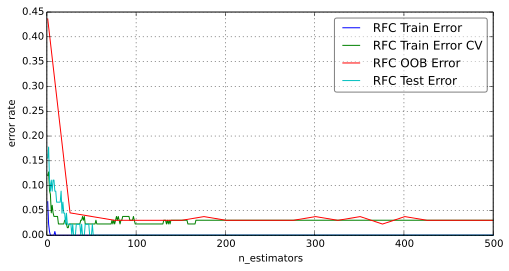

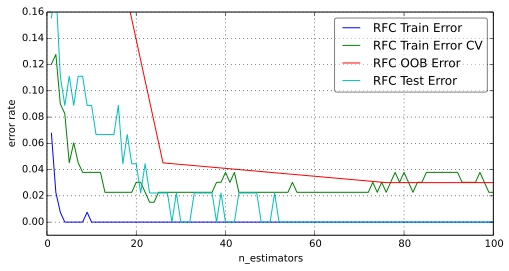

In [29]:
dataSet = wine

X = dataSet['X']
y = dataSet['y']

#Lets split the data making TtD and TD
X_TD, X_TtD, y_TD, y_TtD = cross_validation.train_test_split(X, y, test_size=0.25, random_state=42)


n_estimators = 500
x_bound=[0,100]
y_bound=[-0.01,0.16]

clf = myRandomForestClassifier(n_estimators=n_estimators, max_depth=5)
# wine_error_5 = plot_error(clf, X_TD, X_TtD, y_TD, y_TtD, n_estimators)

wine_p1 = plot_fig(wine_error_5, x_bound=[0,n_estimators], y_bound=None)
wine_p2 = plot_fig(wine_error_5, x_bound, y_bound)

wine_p1.show()
wine_p2.show()

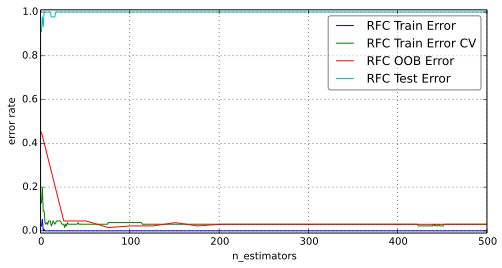

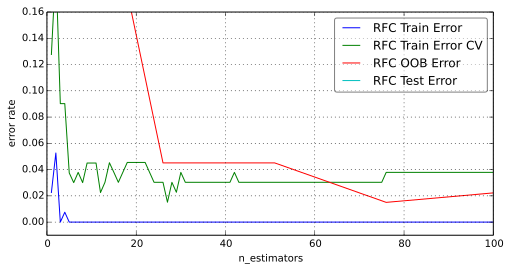

In [31]:
clf = myRandomForestClassifier(n_estimators=n_estimators, max_depth=None)
# wine_error_N = plot_error(clf, X_TD, X_TtD, y_TD, y_TtD, n_estimators)

wine_p3 = plot_fig(wine_error_N, x_bound=[0,n_estimators], y_bound=[-0.01,1.01])
wine_p4 = plot_fig(wine_error_N, x_bound, y_bound)

wine_p3.show()
wine_p4.show()